# Неделя 6. Оценка потенциального экономического эффекта от внедрения полученного решения

## Константинов Вячеслав

## 1. Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt

from scipy import stats as ss
from scipy.sparse import csr_matrix, hstack, vstack

In [2]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import RidgeClassifier, SGDClassifier, LogisticRegression

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer, Imputer
from sklearn.decomposition import PCA

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import average_precision_score, precision_recall_fscore_support, roc_auc_score

from sklearn.svm import LinearSVC 
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit, GridSearchCV

In [3]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import ClusterCentroids, RandomUnderSampler, NearMiss, InstanceHardnessThreshold
from collections import Counter, defaultdict

In [4]:
# Функция для преобразования данных
# num_cols - числовые признаки, которые будут использоваться
# cat_cols - категориальные признаки, которые будут использоваться
# опции: is_OHE - One Hot Encoding, 
# is_OverSampling - Over Sampling
# imput_method - способ заполнения пропущенных числовых данных
# feature_selection - метод отбора признаков 

# По умолчанию используется все признаки, все опции выключены, imput_method='normalize'
# Для обработки категориальных данных по умолчанию используется только Label Encoder

def transform_data(data, y=None, imput_method='normalize', feature_selection=None,
                   num_cols=None, cat_cols=None, is_OHE=False, is_OverSampling=False):
    
    to_return = {}
    
    num_interval = (0, 190)
    cat_interval = (191, data.shape[1])
    
    
    data, num_interval, cat_interval, new_cols = drop_null_cols(data, num_interval, cat_interval)
    
    data_num, data_cat = split_num_cat(data, num_interval)
    
    if num_cols:
        data_num = data[num_cols]
        num_interval = (0, len(num_cols))
        diff = 190 - len(num_cols)
        cat_interval = (191 - diff, data.shape[1]-diff)
        new_cols.drop(num_cols)
    if cat_cols:
        data_cat = data[cat_cols]
        cat_interval_prev = cat_interval
        cat_interval = (cat_interval_prev[0], cat_interval_prev[1]-len(cat_cols))
        new_cols.drop(cat_cols)
    
    print('Processing the numeric columns...')
    data_num = data_num_processing(data_num, method=imput_method)
        
    print('Processing the categorical columns...')
    data_cat = data_cat_fill_nan(data_cat)
    
    data_cat = data_cat_LE(data_cat)
    
    if is_OHE:    
        data_cat = data_cat_OHE(data_cat)
        
    data_result = data_join(data_num, data_cat).tocsr()
    
    if feature_selection:
        data_result, model, feature_importances, feature_ranking = data_feature_selection(data=data_result, y=y, 
                                                                         method=feature_selection,
                                                                         num_interval=num_interval,
                                                                         columns=new_cols, is_OHE=is_OHE)
                                                                         
        to_return['feature_importances'] = feature_importances
        to_return['model'] = model
        to_return['feature_ranking']=feature_ranking
        
    
    if is_OverSampling:
        data_result, to_return['y'] = data_OverSampling(data_result, y)
    
    to_return['X'] = data_result
    to_return['num_interval'] = num_interval
    to_return['cat_interval'] = cat_interval
        
    print('Done!')
    
    return to_return

In [64]:
# Функция удаления пустых колонок

def drop_null_cols(data, num_interval, cat_interval):
    
    print('Dropping the null columns...')
    dropped_num = []
    dropped_cat = []
    
    new_cols = data.columns
    
    for idx, each_col in enumerate(data.columns):
        if len(data[pd.isnull(data[each_col])==True])==data.shape[0]:
            if idx > 190:
                dropped_cat.append(each_col)
            else:
                dropped_num.append(each_col)
                
    for each_col in dropped_num:
        data.drop(each_col,axis = 1,inplace = True)
        print("Dropped num-type column: {0}".format(each_col))
    
    for each_col in dropped_cat:
        data.drop(each_col,axis = 1,inplace = True)
        print("Dropped cal-type column: {0}".format(each_col))
    
    max_num = 190 - len(dropped_num)
    
    print("Dropped {0} num-type cols and {1} cat-types cols".format(len(dropped_num), len(dropped_cat)))
    print("Num-type feature have the indices from {0} up to {1}.".format(0, max_num))
    print("Cal-type feature have the indices from {0} up to {1}.".format(max_num+1, data.shape[1]))
    
    new_cols = new_cols.drop(dropped_num).drop(dropped_cat)
    
    
    return data, (0, max_num), (max_num+1, data.shape[1]), new_cols

# Функция разделения числовых и категориальных признаков

def split_num_cat(data, num_interval):
    print('Splitting the numeric and categorical columns...')
    data_num, data_cat = np.split(data, [num_interval[1]], axis=1)
    return data_num, data_cat

# Функция обработки числовых данных
def data_num_processing(data_num, method='normalize'):
    
    if method == 'normalize':
        print('Filling the absent values with the columns\' means...')
        data_num_transformed = data_num.fillna(data_num.mean())
        print('Normalizing the data...')
        for each_col in data_num_transformed.columns:
            if data_num_transformed[each_col].std():
                data_num_transformed[each_col]=(data_num_transformed[each_col]-data_num_transformed[each_col].mean()) / float(data_num_transformed[each_col].std())
            else:
                data_num_transformed[each_col]=data_num_transformed[each_col]-data_num_transformed[each_col].mean()
    else:
        imputer = Imputer(strategy=method)
        columns = data_num.columns
        data_num_transformed = pd.DataFrame(imputer.fit_transform(data_num), columns=columns)
        
    return data_num_transformed

# Заполнение пустых ячеек категориальных признаков значением 'unknown'
def data_cat_fill_nan(data_cat):
    print('Filling the absent categorical values...')
    data_cat_trasformed = data_cat.fillna('unknown')
    return data_cat_trasformed

# Применение Label Encoder к категориальным данным
def data_cat_LE(data_cat):
    print('Applying a LabelEncoder to the categorical columns...')
    
    data_cat = data_cat.apply(lambda x: x.astype(str))
    data_cat_transformed = data_cat.apply(lambda x: x.astype('category'))
    
    MyLabelEncoder = defaultdict(LabelEncoder)
    data_cat_transformed = data_cat_transformed.apply(lambda x: MyLabelEncoder[x.name].fit_transform(x))
    
    return data_cat_transformed

# Применение One Hot Encoder к категориальным данным

def data_cat_OHE(data_cat):
    print('Applying a OneHotEncoder to categorical columns...')
    data_cat_transformed = OneHotEncoder().fit_transform(data_cat)
    return data_cat_transformed

# Соединение обработанных числовых и категориальных признаков после обработки

def data_join(data_num, data_cat):
    print('Joining the numerical and categorical columns...')
    data_num_sparsed = csr_matrix(data_num)
    data_cat_sparsed = csr_matrix(data_cat)
    
    data_result = hstack((data_num_sparsed, data_cat))
    
    return data_result

# OverSampling
# Применимо только если есть значения labels

def data_OverSampling(data, labels):
    print('OverSampling in progress...')
    ros = RandomOverSampler(random_state=0)
    X_num_cat_resampled, y_resampled = ros.fit_sample(data, labels)
    return X_num_cat_resampled, y_resampled

# Отбор признаков
# Доступны два метода: l1-регуляризация и отбор на основе деревьев
def data_feature_selection(data, y, method, num_interval, columns, is_OHE):
    print('Appling the {}-based feature selection method'.format(method))
    if method == 'l1':
        lsvc = LinearSVC(C=0.01, penalty='l1', dual=False).fit(data, y)
        model = SelectFromModel(lsvc, prefit=True)
        data_transformed = model.transform(data)
        print('New shape of X-data is {}'.format(data_transformed.shape))
        importances = lsvc.coef_
    elif method == 'tree':
        clf = ExtraTreesClassifier().fit(data, y)
        model = SelectFromModel(clf, prefit=True)
        data_transformed = model.transform(data)
        print('New shape of X-data is {}'.format(data_transformed.shape))
        importances = clf.feature_importances_
        
    if not is_OHE:
        features_ranking = columns[importances.argsort()]
    else:
        indices = np.arange(num_interval[1])
        num_importances = np.take(np.array(importances), indices)
        features_ranking = columns[num_importances.argsort()]
    
    return data_transformed, model, importances, features_ranking

# Функция расчета метрик отложенной выборки
def get_scores_hold_out(X_hold_out, y_hold_out, Classifier, configuration, scores):
    
    print('Calculating scores...')
    
    y_proba = Classifier.predict_proba(X_hold_out)[:, 1]
    y_pred = Classifier.predict(X_hold_out)

    results = precision_recall_fscore_support(y_hold_out, y_pred)
    pr_scores = average_precision_score(y_hold_out, y_proba)
    roc_auc_scores = roc_auc_score(y_hold_out, y_proba)
    
    scores.loc[configuration, 'precision'] = results[0][1]
    scores.loc[configuration, 'recall'] = results[1][1]
    scores.loc[configuration, 'f1-score'] = results[2][1]
    
    scores.loc[configuration, 'PR-score'] = pr_scores
    scores.loc[configuration, 'ROC AUC'] = roc_auc_scores
    
    print('Done!')
    return True

# Функция расчета метрик основной выборки
def get_scores(X, y, Classifier, configuration, scores):
    
    skf = StratifiedKFold(n_splits=5, random_state=123)
    skf.get_n_splits(X, y)
    skf.split(X, y)
    
    print('Calculating scores...')
    results = cross_validate(Classifier, X, y, cv=skf, scoring=['precision', 'recall', 'f1', 'average_precision', 'roc_auc'], return_train_score=True)
    
    scores.loc[configuration, 'precision test'] = results['test_precision'].mean()
    scores.loc[configuration, 'precision train'] = results['train_precision'].mean()
    scores.loc[configuration, 'recall test'] = results['test_recall'].mean()
    scores.loc[configuration, 'recall train'] = results['train_recall'].mean()
    scores.loc[configuration, 'f1-score test'] = results['test_f1'].mean()
    scores.loc[configuration, 'f1-score train'] = results['train_f1'].mean()
    scores.loc[configuration, 'PR-score test'] = results['test_average_precision'].mean()
    scores.loc[configuration, 'PR-score train'] = results['train_average_precision'].mean()
    scores.loc[configuration, 'ROC AUC test'] = results['test_roc_auc'].mean()
    scores.loc[configuration, 'ROC AUC train'] = results['train_roc_auc'].mean()
    
    print('Done!')
    return True

In [65]:
# Функция отрисовки кривых обучения
# Взято отсюда: http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve(estimator, title, X, y, scoring=None, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    
    if scoring:
        plt.ylabel(scoring)
    else:
        plt.ylabel('Score')
    
    if scoring:
        train_sizes, train_scores, test_scores = learning_curve(
            estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
        
    else:
        train_sizes, train_scores, test_scores = learning_curve(
            estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
        
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [66]:
# Функция для изменения размера выборки с указанием доли положительного и отрицательного классов
# pos_frac - доля объектов положительного класса начальной выборки, которые будут использоваться в итоговой выборке
# neg_frac - доля объектов отрицательного класса начальной выборки, которые будут использоваться в итоговой выборке

def resample_data(X, y, pos_frac, neg_frac):
    
    pos_size = int(len(np.where(y==1)[0]) * pos_frac)
    neg_size = int(len(np.where(y==-1)[0]) * neg_frac)
    
    random.seed(1)
    pos_indices = random.sample(list(np.where(y== 1)[0]), pos_size)
    neg_indices = random.sample(list(np.where(y==-1)[0]), neg_size)
    
    y_pos = y[pos_indices]
    y_neg = y[neg_indices]
    y_result = np.append(y_pos, y_neg).ravel()
    
    X_pos = X[pos_indices]
    X_neg = X[neg_indices]
    X_result = vstack((X_pos, X_neg))
    
    pos_rate_result = X_result[y_result==1].shape[0] / float(X_result.shape[0])
    neg_rate_result = X_result[y_result==-1].shape[0] / float(X_result.shape[0])
    shape_result = X_result.shape[0]
    
    print('The new size is {0}, the positive and negative class fractions are {1:.2f} and {2:.2f}'.format(shape_result, pos_rate_result, neg_rate_result))

    return X_result, y_result, pos_rate_result, neg_rate_result, shape_result

In [108]:
scores_cv = pd.DataFrame(columns = ['precision test', 'precision train', 'recall test', 'recall train', 'f1-score test', 'f1-score train','PR-score test','PR-score train', 'ROC AUC test', 'ROC AUC train'])
scores_train = pd.DataFrame(columns = ['precision', 'recall', 'f1-score', 'PR-score', 'ROC AUC'])

In [109]:
data = pd.read_csv('orange_small_churn_data.txt', header=0, sep=',')
labels = pd.read_csv('orange_small_churn_labels.txt', header=None)
labels.columns = ['target']
labels = labels.apply(lambda x: x.astype(int))

y = labels.as_matrix().ravel()

In [110]:
data_result_model = transform_data(data=data, y=y, feature_selection='tree')

Dropping the null columns...
Dropped num-type column: Var8
Dropped num-type column: Var15
Dropped num-type column: Var20
Dropped num-type column: Var31
Dropped num-type column: Var32
Dropped num-type column: Var39
Dropped num-type column: Var42
Dropped num-type column: Var48
Dropped num-type column: Var52
Dropped num-type column: Var55
Dropped num-type column: Var79
Dropped num-type column: Var141
Dropped num-type column: Var167
Dropped num-type column: Var169
Dropped num-type column: Var175
Dropped num-type column: Var185
Dropped cal-type column: Var209
Dropped cal-type column: Var230
Dropped 16 num-type cols and 2 cat-types cols
Num-type feature have the indices from 0 up to 174.
Cal-type feature have the indices from 175 up to 212.
Splitting the numeric and categorical columns...
Processing the numeric columns...
Filling the absent values with the columns' means...
Normalizing the data...
Processing the categorical columns...
Filling the absent categorical values...
Applying a Label

In [112]:
gbc = GradientBoostingClassifier(learning_rate=0.1, n_estimators=120)

In [ ]:
near_miss = NearMiss(random_state=0)
X_resampled_LE, y_resampled_LE = near_miss.fit_sample(data_result_model['X'], y)

In [114]:
X_train, X_hold_out, y_train, y_hold_out = train_test_split(X_resampled_LE, y_resampled_LE, 
                                                            test_size=0.2, random_state=123, 
                                                            stratify=y_resampled_LE)

In [115]:
get_scores(X_train, y_train, gbc, 'final model', scores_cv)

Calculating scores...
Done!


True

In [116]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=120,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [117]:
get_scores_hold_out(X_hold_out, y_hold_out, gbc, 'final model', scores_train)

Calculating scores...
Done!


True

In [118]:
scores_cv

,precision test,precision train,recall test,recall train,f1-score test,f1-score train,PR-score test,PR-score train,ROC AUC test,ROC AUC train
final model,0.817431,0.916082,0.679983,0.776985,0.742204,0.840811,0.875998,0.943659,0.851912,0.932265


In [120]:
scores_train

,precision,recall,f1-score,PR-score,ROC AUC
final model,0.793103,0.618487,0.694995,0.861226,0.836487


In [121]:
y_pred = gbc.predict_proba(X_resampled_LE)[:, 1]

In [122]:
results_gbc = pd.DataFrame(y_pred, columns = ['result'])
results_gbc.index.name = 'Id'
results_gbc.to_csv('week6.csv')

## 2. Оценка экономического эффекта

Постройте простую экономическую модель для оценки эффекта от внедрения полученного решения на практике.

Например, введите следующие параметры:

* сколько денег в среднем приносит один пользователь в месяц;
* сколько денег в среднем вы будете вкладывать в удержание одного пользователя;
* с какой вероятностью пользователь примет ваше предложение;
* сколько пользователей (например, топ 1% или топ 25% согласно ранжированию по вашей модели) будет участвовать в кампании.


1) Введите еще несколько параметров и на их основе постройте простую экономическую модель: формулу по которой в зависимости от значения исходных параметров вы сможете рассчитать экономический эффект от проведения кампании (= сколько денег вы получили (или наоборот потеряли) от проведения кампании по удержанию) с использование вашей модели.

* $ AGU_{28} $ - (28-days average gross per user) столько денег в среднем приносит один пользователь в месяц;
* $ ARCU$ - (28-days average retention costs per user) сколько денег в среднем вкладывается в удержание одного пользователя;
* $p$ - (probability of acceptance) вероятность принятия пользователем предложения;
* $CICF$ - (costumers involved in campaign fraction) - доля TOP пользователей,  отнесенных алгоритмом к классу "отток" и участвующих в кампании по удержанию. $CICF$ - порог модели (threshold), выше - класс "отток", ниже - "не отток"

Экономическим эффектом будем считать разницу дохода в случае проведения кампании и дохода, который был бы получен без проведения кампании. 

Для оценки эффекта разобъем пользователей на 4 группы:
* $TP$ (true positive) - те пользователи, которых модель отнесла к классу "отток" и которые действительно собираются уходить; 
* $FP$ (false positive) - те пользователи, которых модель отнесла к классу "отток", но которые на самом деле **не собираются уходить**; 
* $TN$ (true negative) - те пользователи, которых модель отнесла к классу "не отток" и которые действительно не собираются уходить;
* $FN$ (false negative) - те пользователи, которых модель отнесла к классу "не отток", но которые в действительности **собираются уходить**

$TP$, $FP$, $TN$ и $FN$ зависят от $CICF$ 

Рассчитаем экономический эффект для каждой из 4 групп.

** TP **

* Без проведения кампании они уйдут и принесут убыток: $-TP \cdot AGU_{28}$
* С проведением кампании: $p \cdot TP \cdot (AGU_{28} - ARCU) - (1-p)\cdot TP \cdot AGU_{28} $
* Итого: $p \cdot TP \cdot (AGU_{28} - ARCU) - (1-p)\cdot TP \cdot ARCU +TP \cdot AGU_{28} = 2p \cdot TP \cdot AGU_{28} -TP \cdot AGU_{28} - p\cdot TP \cdot ARCU$

** FP **

* Без проведения кампании они все равно останутся и принесут доход: $FP \cdot AGU_{28}$
* С проведением кампании: $(1-p) \cdot FP \cdot AGU_{28} -  p \cdot FP \cdot ARCU$
* Итого: $FP \cdot AGU_{28} -  p \cdot FP \cdot ARCU - FP \cdot AGU_{28} =-  p \cdot FP \cdot ARCU $

** TN **

* Без проведения кампании они все равно останутся и принесут доход: $TN \cdot AGU_{28}$
* С проведением кампании тоже останутся : $TN \cdot AGU_{28}$
* Итого: $TN \cdot AGU_{28} - TN \cdot AGU_{28} = 0 $

** FN **

* Без проведения кампании они все равно уйдут и принесут убыток: $ -FN \cdot AGU_{28}$
* С проведением кампании тоже уйдут и принесут убыток:: $ -FN \cdot AGU_{28}$
* Итого: $-FN \cdot AGU_{28} - (-FN \cdot AGU_{28}) = 0 $

Учтем ограниченность бюджета кампании TB:

$$ (TP+FP) \cdot ARCU \leqslant TB $$

** Итоговые формулы для максимизации экономического эффекта** TE (total effect) выглядят следующим образом:

$$TE = 2p \cdot TP \cdot AGU_{28} - p\cdot TP \cdot ARCU -  p \cdot FP \cdot ARCU   \rightarrow max~(1) $$

$$ p \cdot (TP+FP) \cdot ARCU \leqslant TB~(2)$$

2) Исходя из введенных параметров проанализируйте, какой топ пользователей, склонных к оттоку согласно модели, оптимально выбрать для проведения кампании по удержанию для таким образом, чтобы экономический эффект был наибольшим?

In [372]:
def is_less_than_tb(TP, FP, ARCU, p, TB):
    return p*(TP + FP)*ARCU <= TB


def total_effect(AGU_28, ARCU, p, CICF, TB):
    
    threshold = np.percentile(y_pred, 100 - CICF, axis=None)
    is_involved = (y_pred > threshold).astype(int)
    
    TP = ((y_resampled_LE == 1) & (is_involved == 1)).sum()
    FP = ((y_resampled_LE == -1) & (is_involved == 1)).sum()
 
    if not is_less_than_tb(TP, FP, ARCU, p, TB):
        return None
    
    return 2*p*TP*AGU_28 - p*TP*ARCU - p*FP*ARCU

def plot_total_effect(AGU_28, ARCU, p, TB, label_type=None):
    c = np.linspace(0, 100, 200)
    TE = []
    for each_cicf in c:
        tot_eff = total_effect(AGU_28, ARCU, p, each_cicf, TB)
        if tot_eff is None:
            continue
        TE.append((each_cicf, tot_eff))

    xs, ys = zip(*TE)
    
    if label_type=='AGU_28':
        label=f'AGU_28={AGU_28}'
    elif label_type=='ARCU':
        label=f'ARCU={ARCU}'
    elif label_type=='p':
        label=f'p={p}'
    elif label_type=='TB':
        label=f'TB={TB}'
    else:
        label=f'AGU_28={AGU_28}, ARCU={ARCU}, p={p}, TB={TB}'
        
    
    plt.plot(xs, ys, label=label)
    
    plt.title('Total effect (CICF)')
    plt.ylabel('Total effect')
    plt.xlabel("CICF")

    CICF = round(xs[np.argmax(np.array(ys))], 2)
    effect = int(np.array(ys).max())
    
    print(f'AGU_28={AGU_28}, ARCU={ARCU}, p={round(p, 4)}, TB={TB}')
    print(f'The max total effect={effect}, with CICF={CICF}%')
    
    return (xs[np.argmax(np.array(ys))], np.array(ys).max())

AGU_28=300, ARCU=125, p=0.2, TB=200000
The max total effect=232105, with CICF=69.35%


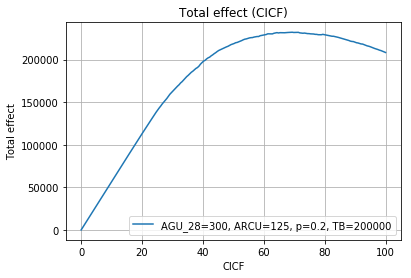

In [373]:
AGU_28 = 300
ARCU = 125
p = 0.2
TB = 200000

plot_total_effect(AGU_28, ARCU, p, TB)

plt.grid()
plt.legend(loc="best")
plt.show()

При $AGU_{28} = 300$, $ARCU = 125$, $p = 0.2$, $TB = 200000$ для максимизации экономического эффекта необходимо взять ТОП $CICF=70\%$

3) Попробуйте усложнить экономическую модель. Добавьте еще несколько параметров и поиграйте с ними (например, измените стоимость удержания и вероятность, с которой пользователь принимает предложение), проанализируйте как меняется оптимальный размер топа?

Попробуем учесть, что желание принять предложение будет расти с увеличением стоимости удержания:

$$ p(\alpha) = \begin{cases} e^{\alpha \cdot \frac{ARCU}{100 \cdot AGU_{28}}-1}, & ARCU \leqslant AGU_{28} \\ 1, & ARCU > AGU_{28} \end{cases} (3)$$

In [381]:
import math

def p_alpha(AGU_28, ARCU, alpha):
    if ARCU>AGU_28:
        return 1.
    else:
        return math.exp(float(alpha*ARCU)/(100.*AGU_28) - 1.)

AGU_28=300, ARCU=100, p=0.3679, TB=200000
The max total effect=465923, with CICF=79.4%
AGU_28=300, ARCU=125, p=0.368, TB=200000
The max total effect=427022, with CICF=69.35%
AGU_28=300, ARCU=150, p=0.368, TB=200000
The max total effect=388853, with CICF=60.8%
AGU_28=300, ARCU=175, p=0.368, TB=200000
The max total effect=349596, with CICF=51.76%
AGU_28=300, ARCU=200, p=0.368, TB=200000
The max total effect=313464, with CICF=45.23%
AGU_28=300, ARCU=225, p=0.368, TB=200000
The max total effect=276592, with CICF=40.2%


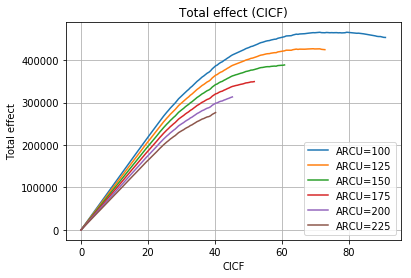

In [384]:
AGU_28 = 300
ARCU = [100, 125, 150, 175, 200, 225]
alpha=0.05
p = [p_alpha(AGU_28, each_arcu, alpha) for each_arcu in ARCU]
TB = 200000

for each_arcu, each_p in zip(ARCU, p):
    plot_total_effect(AGU_28, each_arcu, each_p, TB, 'ARCU')
plt.grid()
plt.legend(loc="best")
plt.show()

С увеличением стоимости стоимости $ARCU$ удержания ТОП $CICF$ уменьшается

AGU_28=300, ARCU=100, p=0.2, TB=200000
The max total effect=253260, with CICF=79.4%
AGU_28=300, ARCU=125, p=0.2, TB=200000
The max total effect=232105, with CICF=69.35%
AGU_28=300, ARCU=150, p=0.2, TB=200000
The max total effect=212520, with CICF=64.32%
AGU_28=300, ARCU=175, p=0.2, TB=200000
The max total effect=193765, with CICF=61.31%
AGU_28=300, ARCU=200, p=0.2, TB=200000
The max total effect=176080, with CICF=55.28%
AGU_28=300, ARCU=225, p=0.2, TB=200000
The max total effect=159960, with CICF=53.77%


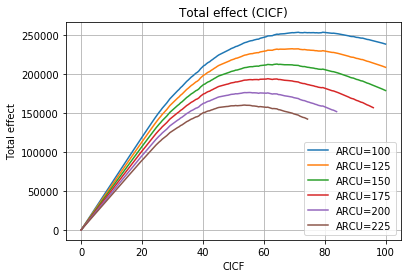

In [385]:
AGU_28 = 300
ARCU = [100, 125, 150, 175, 200, 225]
p = 0.2
TB = 200000

for each_arcu in ARCU:
    plot_total_effect(AGU_28, each_arcu, p, TB, label_type='ARCU')
plt.grid()
plt.legend(loc="best")
plt.show()

С увеличением стоимости стоимости $ARCU$ удержания ТОП $CICF$ уменьшается

AGU_28=200, ARCU=100, p=0.2, TB=200000
The max total effect=141680, with CICF=64.32%
AGU_28=225, ARCU=100, p=0.2, TB=200000
The max total effect=168960, with CICF=64.32%
AGU_28=250, ARCU=100, p=0.2, TB=200000
The max total effect=196860, with CICF=69.35%
AGU_28=300, ARCU=100, p=0.2, TB=200000
The max total effect=253260, with CICF=79.4%
AGU_28=325, ARCU=100, p=0.2, TB=200000
The max total effect=282240, with CICF=79.4%
AGU_28=350, ARCU=100, p=0.2, TB=200000
The max total effect=311220, with CICF=79.4%


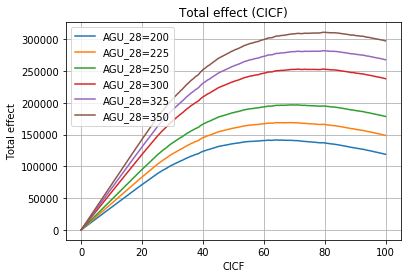

In [405]:
AGU_28 = [200, 225, 250, 300, 325, 350]
ARCU = 100
p = 0.2
TB = 200000

for each_agu in AGU_28:
    plot_total_effect(each_agu, ARCU, p, TB, label_type='AGU_28')
plt.grid()
plt.legend(loc="best")
plt.show()

С увеличением дохода, приносимого одним пользователем в месяц, $AGU_{28}$ ТОП $CICF$ увеличивается

AGU_28=300, ARCU=100, p=0.05, TB=200000
The max total effect=63315, with CICF=79.4%
AGU_28=300, ARCU=100, p=0.1, TB=200000
The max total effect=126630, with CICF=79.4%
AGU_28=300, ARCU=100, p=0.15, TB=200000
The max total effect=189945, with CICF=79.4%
AGU_28=300, ARCU=100, p=0.2, TB=200000
The max total effect=253260, with CICF=79.4%
AGU_28=300, ARCU=100, p=0.25, TB=200000
The max total effect=316575, with CICF=79.4%
AGU_28=300, ARCU=100, p=0.3, TB=200000
The max total effect=379890, with CICF=79.4%
AGU_28=300, ARCU=100, p=0.35, TB=200000
The max total effect=443205, with CICF=79.4%


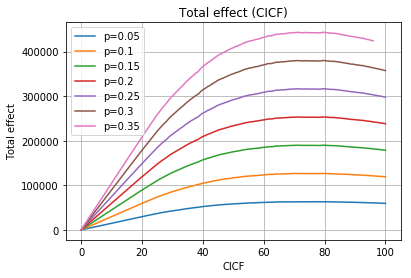

In [387]:
AGU_28 = 300
ARCU = 100
p = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
TB = 200000

for each_p in p:
    plot_total_effect(AGU_28, ARCU, each_p, TB, label_type='p')
plt.grid()
plt.legend(loc="best")
plt.show()

С изменением вероятности принятия предложения $p$ ТОП $CICF$ не меняется

4) Всегда ли применение модели экономически оправданно? Приведите пример набора значений параметров, при которых применение модели перестает быть оправданным.

Модель экономически оправдана, пока эффект неотрицателен, то есть:

$$TE = 2p \cdot TP \cdot AGU_{28} - p\cdot TP \cdot ARCU -  p \cdot FP \cdot ARCU  \geqslant 0 \mbox{ (4)}$$

$$ p \cdot (2 \cdot TP \cdot AGU_{28} -  TP \cdot ARCU - FP \cdot ARCU)  \geqslant 0 \mbox{ (5)}$$

Учтём, что $p>0$

$$ 2 \cdot TP \cdot AGU_{28} -  ARCU \cdot (TP + FP)  \geqslant 0 \mbox{ (6)}$$

$TP + FP > 0$, откуда получим, что:

$$ \frac{TP}{TP + FP} \geqslant \frac{ARCU}{2 \cdot AGU_{28}} \mbox{ (7)}$$

В левой части (7) стоит точность. Таким образом, экономическая модель опрадана, если точность модели удовлетворяет соотношению:

$$ precision \geqslant \frac{ARCU}{2 \cdot AGU_{28}} \mbox{ (8)}$$

Или, что равносильно, траты на удержание одного пользователя удовлетворяют неравенству:

$$ ARCU \leqslant 2 \cdot AGU_{28} \cdot precision \mbox{ (9)}$$

* Например, если точность модели $p=0.7$ средний доход на одного пользователя в месяц $AGU_{28} = 200$, то модель перестаёт быть экономически оправданной при тратах на удержание $ARCU > 280$;

* Также надо учитывать то, что иногда эффект от удержания может быть меньше, чем от привлечения новых пользователей с учётом месячной конверсии. В данной модели стоимость привлечения не учитывалась.

5) Оцените изменение экономического эффекта от проведения кампании по удержанию при увеличении качества модели на 1%? На 3%? При ответе на вопрос укажите, по какой метрике вы оцениваете качество.


Перепишем (1) и (4) в следующем виде:

$$TE(precision) = 2 \cdot p \cdot AGU_{28} \cdot precision - p \cdot ARCU \mbox{ (10)}$$

Или в приращениях:

$$\Delta TE(\Delta precision) = 2 \cdot p \cdot AGU_{28} \cdot \Delta precision \mbox{ (11)}$$

Исходя из (11), получается, что улучшение точности модели на 1% и на 3% увеличит экономический эффект на 1% и на 3% соответственно.

6) Как вы думаете, является ли экономически оправданным вложение средств в улучшение качества модели? На сколько нужно улучшить модель, чтобы это качественно сказалось на экономическом эффекте от удержания?

* Улучшение модели оправдано до тех пор, пока увеличение экономического эффекта $\Delta TE$ не меньше, чем траты на улучшение модели на $\beta$  п.п.  $MIC(\beta)$ (model improvement costs):

$$ \Delta TE \geqslant MIC(\beta) \mbox{ (12)}$$

* Качественным улучшением будем считать такое улучшение, при котором приращение эффекта за вычетом затрат на улучшение выше заданного порога $\gamma$, например, в $\gamma = 10\%$:

$$ \frac{\Delta TE - MIC(\beta)}{TE_{0}} \geqslant \gamma = 0.1 \mbox{ (13)}$$

* В (13) порог качественного улучшения $\gamma$ задаётся в зависимости от конкретных целевых показателей и поставленных задач. Исходя из заданного $\gamma$, соотношения (13) и характера зависимости $MIC(\beta)$, можно найти конкретное значение приращения точности модели, которое качественно улучшит модель.